In [33]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn import metrics
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 

### Data import

In [34]:
data = pd.read_excel('Delivery truck trip data.xls')

### Data Transformation

In [35]:
transport = data.drop(['GpsProvider','BookingID_Date','vehicle_no','Origin_Location','Destination_Location','Org_lat_lon','Des_lat_lon','Data_Ping_time','Planned_ETA',
                       'Current_Location','DestinationLocation','actual_eta','Curr_lat','Curr_lon','vehicleType','Minimum_kms_to_be_covered_in_a_day','Driver_MobileNo',
                       'customerNameCode','supplierNameCode','Material Shipped', 'trip_end_date', 'delay'], axis=1)
transport.describe()

,TRANSPORTATION_DISTANCE_IN_KM
count,6168.000000
mean,553.856282
std,758.981836
min,0.000000
25%,40.000000
50%,160.000000
75%,900.000000
max,2954.700000


In [36]:
transport.head()

,BookingID,Market,ontime,OriginLocation_Code,DestinationLocation_Code,trip_start_date,TRANSPORTATION_DISTANCE_IN_KM,Driver_Name,customerID,supplierID
0,MVCV0000927/082021,Market,NaN,CHEPUZTVSHUA1,HOSHOSALLCCA2,2020-08-17 14:59:01,320.0,NaN,ALLEXCHE45,VIJEXHOSR7
1,VCV00014271/082021,Regular,G,CHEORADMRCCB1,CHEMATDMROPA7,2020-08-27 16:21:52,103.0,RAMESH,DMREXCHEUX,VJLEXSHE09
2,VCV00014382/082021,Regular,G,CHEPONLUTCCA4,CHEPONLUTCCA4,2020-08-27 17:57:04,300.0,GIRI,LUTGCCHE06,GSTEXLAK1Q
3,VCV00014743/082021,Regular,G,CHEORADMRCCB1,CHEMATDMROPA7,2020-08-28 00:47:45,61.0,RAVI,DMREXCHEUX,ARVEXNAM09
4,VCV00014744/082021,Regular,G,CHENETLUTCCA1,CHENETLUTCCA1,2020-08-28 01:13:48,240.0,TAMIL,LUTGCCHE06,SRTEXKOR96


In [37]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

transport.ontime = transport.ontime.fillna('').apply(str)
newcol = le.fit_transform(transport.ontime.values)
transport.loc[:,'ontime'] = newcol

transport.Market = transport.Market.fillna('').apply(str)
newcol = le.fit_transform(transport.Market.values)
transport.loc[:,'Market'] = newcol

transport.DestinationLocation_Code = transport.DestinationLocation_Code.fillna('').apply(str)
newcol = le.fit_transform(transport.DestinationLocation_Code)
transport.loc[:,'DestinationLocation_Code'] = newcol

transport.customerID = transport.customerID.fillna('').apply(str)
newcol = le.fit_transform(transport.customerID)
transport.loc[:,'customerID'] = newcol

transport.supplierID = transport.supplierID.fillna('').apply(str)
newcol = le.fit_transform(transport.supplierID)
transport.loc[:,'supplierID'] = newcol

transport.OriginLocation_Code = transport.OriginLocation_Code.fillna('').apply(str)
newcol = le.fit_transform(transport.OriginLocation_Code)
transport.loc[:,'OriginLocation_Code'] = newcol

transport.Driver_Name = transport.Driver_Name.fillna('').apply(str)
newcol = le.fit_transform(transport.Driver_Name)
transport.loc[:,'Driver_Name'] = newcol

transport.TRANSPORTATION_DISTANCE_IN_KM = transport.TRANSPORTATION_DISTANCE_IN_KM.fillna(0)

In [38]:
transport.head()

,BookingID,Market,ontime,OriginLocation_Code,DestinationLocation_Code,trip_start_date,TRANSPORTATION_DISTANCE_IN_KM,Driver_Name,customerID,supplierID
0,MVCV0000927/082021,0,0,30,136,2020-08-17 14:59:01,320.0,0,0,317
1,VCV00014271/082021,1,1,21,17,2020-08-27 16:21:52,103.0,906,5,319
2,VCV00014382/082021,1,1,27,34,2020-08-27 17:57:04,300.0,336,20,286
3,VCV00014743/082021,1,1,21,17,2020-08-28 00:47:45,61.0,928,5,272
4,VCV00014744/082021,1,1,20,23,2020-08-28 01:13:48,240.0,1223,20,310


In [39]:
transport.describe()

,Market,ontime,OriginLocation_Code,DestinationLocation_Code,TRANSPORTATION_DISTANCE_IN_KM,Driver_Name,customerID,supplierID
count,6880.000000,6880.000000,6880.000000,6880.000000,6880.000000,6880.000000,6880.000000,6880.000000
mean,0.989971,0.370349,94.801744,208.548692,496.538597,342.842587,15.954651,162.984884
std,0.099649,0.482933,55.907278,140.970489,738.169703,430.478602,7.770661,84.042330
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,31.000000,78.000000,30.000000,0.000000,7.000000,79.000000
50%,1.000000,0.000000,119.000000,218.000000,109.000000,5.000000,19.000000,148.000000
75%,1.000000,1.000000,146.000000,318.000000,660.000000,688.000000,19.000000,240.000000
max,1.000000,1.000000,178.000000,478.000000,2954.700000,1355.000000,38.000000,320.000000


In [40]:
transport.corr()

,Market,ontime,OriginLocation_Code,DestinationLocation_Code,TRANSPORTATION_DISTANCE_IN_KM,Driver_Name,customerID,supplierID
Market,1.000000,-0.085928,0.083847,0.017332,-0.005272,0.080167,0.074319,-0.155582
ontime,-0.085928,1.000000,-0.380596,-0.299510,-0.168406,0.091183,-0.130485,0.329443
OriginLocation_Code,0.083847,-0.380596,1.000000,0.630053,-0.417857,-0.433533,0.316721,-0.676412
DestinationLocation_Code,0.017332,-0.299510,0.630053,1.000000,-0.368005,-0.343826,0.293046,-0.574666
TRANSPORTATION_DISTANCE_IN_KM,-0.005272,-0.168406,-0.417857,-0.368005,1.000000,0.371291,-0.294096,0.204647
Driver_Name,0.080167,0.091183,-0.433533,-0.343826,0.371291,1.000000,-0.306958,0.375106
customerID,0.074319,-0.130485,0.316721,0.293046,-0.294096,-0.306958,1.000000,-0.302446
supplierID,-0.155582,0.329443,-0.676412,-0.574666,0.204647,0.375106,-0.302446,1.000000


## Split Dependent and Independent variables & Training and Test data

In [41]:
X, y = transport.drop(['ontime','trip_start_date','BookingID'],axis=1), transport.ontime
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2)

## Predictions!
#### Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression
modelLR = LogisticRegression( max_iter=10000 )
modelLR.fit(Xtrain,ytrain)

LogisticRegression(max_iter=10000)

In [43]:
pd.DataFrame(list(zip(X.columns,np.transpose(modelLR.coef_))))

,0,1
0,Market,[-1.0025266703288838]
1,OriginLocation_Code,[-0.01819088848470301]
2,DestinationLocation_Code,[-0.0031977864293192453]
3,TRANSPORTATION_DISTANCE_IN_KM,[-0.0014625680713679962]
4,Driver_Name,[-2.350428299539698e-05]
5,customerID,[-0.02722641728531324]
6,supplierID,[-0.0004349856177695348]


In [44]:
ypred = modelLR.predict(Xtest)
metrics.accuracy_score(ytest,ypred)

0.813953488372093

In [45]:
modelLR.fit(X,y)
ypred = modelLR.predict(X)

transport.loc[:,'LogRegPredict'] = ypred
metrics.accuracy_score(y,ypred)

0.7976744186046512

#### Decision Tree

In [46]:
from sklearn.tree import DecisionTreeClassifier
modelDT = DecisionTreeClassifier()

In [47]:
modelDT.fit(Xtrain,ytrain)
ypred = modelDT.predict(Xtest)
metrics.accuracy_score(ytest,ypred)

0.8706395348837209

In [48]:
modelDT.fit(X,y)
ypred = modelDT.predict(X)
transport.loc[:,'DecTreePredict'] = ypred
metrics.accuracy_score(y,ypred)

0.9463662790697674

In [49]:
confusion_matrix(y, ypred)

array([[4232,  100],
       [ 269, 2279]], dtype=int64)

Confusion matrix, without normalization


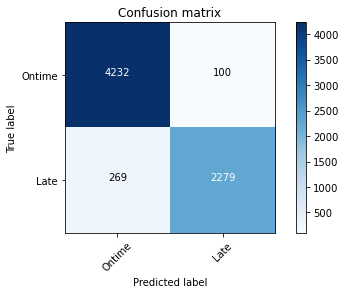

In [50]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(confusion_matrix(y,ypred), classes = ['Ontime', 'Late'])

#### Random Forest

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

cvmethod = StratifiedKFold(n_splits=5, shuffle = True)
modelRF = RandomForestClassifier()

modelRF.fit(Xtrain,ytrain)
ypred = modelRF.predict(Xtest)

metrics.accuracy_score(ytest,ypred)

0.8815406976744186

In [52]:
modelRF.fit(X, y)
ypred = modelRF.predict(X)
transport.loc[:,'RForestPred'] = ypred

metrics.accuracy_score(y,ypred)

0.9463662790697674

#### Gradient Boosting Models (GBM)

In [53]:
from sklearn.ensemble import GradientBoostingClassifier
modelGBM = GradientBoostingClassifier()

modelGBM.fit(Xtrain,ytrain)
ypred = modelGBM.predict(Xtest)

metrics.accuracy_score(ytest,ypred)

0.8699127906976745

In [54]:
modelGBM.fit(X, y)

ypred = modelGBM.predict(X)
transport.loc[:,'GradBoostPredict'] = ypred

metrics.accuracy_score(y, ypred)

0.8646802325581395

#### XGBoost

In [55]:
import xgboost
modelXGB = xgboost.XGBClassifier()

modelXGB.fit(Xtrain,ytrain)
ypred = modelXGB.predict(Xtest)

metrics.accuracy_score(ytest,ypred)

0.8844476744186046

In [56]:
modelXGB.fit(X, y)

ypred = modelXGB.predict(X)
transport.loc[:,'XGBoostPredict'] = ypred

metrics.accuracy_score(y, ypred)

0.9277616279069767

## Save Test Predictions to Excel

In [57]:
import openpyxl

with pd.ExcelWriter('DeliveryTruckPredictNew.xlsx') as writer:
    transport.to_excel(writer)

### Summary so far

Predictive Algoritms performed well (assertivity & execution time)

## Let's Predict over some Fake Data

In [58]:
col = ['Market','OriginLocation_Code','DestinationLocation_Code','TRANSPORTATION_DISTANCE_IN_KM','Driver_Name','customerID','supplierID']

fData2 = []

for i in range(0, 30):
    fData2.append( [ np.random.randint(0,1), np.random.randint(0,178), np.random.randint(0,478), np.random.randint(1,2975),
                        np.random.randint(0,1355), np.random.randint(1,38), np.random.randint(0,320) ])

fData = pd.DataFrame(fData2, columns=col)
predict = pd.DataFrame(fData2, columns=col)

## Let's Build a simple Recommender System
First let's predict using available models

In [29]:
ypred = modelDT.predict(fData)
predict.loc[:,'Predict'] = ypred

with pd.ExcelWriter('DeliveryTruckFakePredictNew.xlsx') as writer:
    predict.to_excel(writer)


predict.head(31)

,Market,OriginLocation_Code,DestinationLocation_Code,TRANSPORTATION_DISTANCE_IN_KM,Driver_Name,customerID,supplierID,Predict
0,0,117,319,2836,432,5,272,1
1,0,156,121,2536,1008,33,315,1
2,0,30,372,451,394,12,121,1
3,0,43,129,1914,476,27,168,0
4,0,17,434,631,519,13,278,1
5,0,117,343,285,703,8,131,0
6,0,4,236,1948,904,35,77,0
7,0,110,347,2732,30,33,205,1
8,0,132,57,164,493,25,31,0
9,0,73,251,136,890,30,305,1


#### Find the Nearest Neighbors
<img src="kNN.png" width="500"/>

In [30]:
#knn=transport.query( 'ontime==0' ).drop_duplicates(['OriginLocation_Code','DestinationLocation_Code'])
knn=transport.drop_duplicates(['OriginLocation_Code','DestinationLocation_Code'])
knn=knn.pivot(index='OriginLocation_Code', columns='DestinationLocation_Code', values='TRANSPORTATION_DISTANCE_IN_KM').fillna(0)
knn.head(21)

DestinationLocation_Code,0,1,2,3,4,5,6,7,8,9,...,469,470,471,472,473,474,475,476,477,478
OriginLocation_Code,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1290.0,1330.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1290.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1020.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,2723.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,1199.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,1900.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,2543.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
for i in range(0,predict.last_valid_index()):
    if predict.loc[ i,'Predict' ] == 1:
        z = predict.loc[i,'OriginLocation_Code']
        print( knn.loc[ [z],0 ] )

OriginLocation_Code
117    0.0
Name: 0, dtype: float64
OriginLocation_Code
156    0.0
Name: 0, dtype: float64
OriginLocation_Code
30    0.0
Name: 0, dtype: float64
OriginLocation_Code
17    0.0
Name: 0, dtype: float64
OriginLocation_Code
110    0.0
Name: 0, dtype: float64
OriginLocation_Code
73    0.0
Name: 0, dtype: float64
OriginLocation_Code
109    0.0
Name: 0, dtype: float64
OriginLocation_Code
142    0.0
Name: 0, dtype: float64
OriginLocation_Code
36    0.0
Name: 0, dtype: float64
OriginLocation_Code
143    0.0
Name: 0, dtype: float64
OriginLocation_Code
143    0.0
Name: 0, dtype: float64
OriginLocation_Code
113    0.0
Name: 0, dtype: float64


### Test Recommended Neighbors

In [32]:
from sklearn.neighbors import NearestNeighbors
modelNn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=2)
modelNn.fit(knn)

recom = pd.DataFrame( columns = col, index=range(predict.last_valid_index()) ).fillna(0)

for i in range(0,predict.last_valid_index()):
    if predict.loc[ i,'Predict' ] == 1:
        z = predict.loc[i,'OriginLocation_Code']
        indices = modelNn.kneighbors(knn.loc[z,:].values.reshape(1,-1), n_neighbors=2, return_distance=False)
        repre = predict.iloc[[i]].drop(columns='Predict')
        recom.iloc[[i]] = repre
        if indices[0,0] == predict.loc[i,'OriginLocation_Code']:
            recom.loc[i,'OriginLocation_Code'] = knn.index[indices[0,1]]
        else:
            recom.loc[i,'OriginLocation_Code'] = knn.index[indices[0,0]]


recom = recom.query( 'OriginLocation_Code != 0')

ypredict = modelDT.predict(recom)
recom.loc[:,'Predict'] = ypredict

recom

,Market,OriginLocation_Code,DestinationLocation_Code,TRANSPORTATION_DISTANCE_IN_KM,Driver_Name,customerID,supplierID,Predict
0,0,22,319,2836,432,5,272,0
1,0,121,121,2536,1008,33,315,1
2,0,5,372,451,394,12,121,0
4,0,18,434,631,519,13,278,1
7,0,1,347,2732,30,33,205,0
9,0,74,251,136,890,30,305,1
13,0,90,57,1011,1035,18,288,1
14,0,71,455,910,418,22,118,0
19,0,1,276,859,453,2,36,1
22,0,120,133,1963,1090,2,44,1
